In [1]:
import os
import mlflow
import smtplib
import numpy as np
import pandas as pd
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
################## CONFIG ##################
EMAIL = "EMAIL"
PASSWORD = "PASSWORD"

DATASET_NAME = "wine"

PARAMS_TO_SCORE_PATH = "params_to_score.jpg"
FEATURE_IMPORTANCE_PATH = "feature_importance.jpg"
FEATURE_CORR_PATH = "features_correlation.png"
############################################

In [3]:
def send_email(to, text, *files):
    try:
        msg = MIMEMultipart('related')
        msg["From"] = EMAIL
        msg["Subject"] = "MLOPS RUN"
        msg["To"] = to
        text_ = MIMEText(text)
        msg.attach(text_)

        for f in files:
            image = MIMEImage(open(f, "rb").read(), name=os.path.basename(f))
            msg.attach(image)
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(EMAIL, PASSWORD)
            server.send_message(msg)
            return True
    except Exception as e:
        print("Failed to send alert email.\nException: " + str(e))


#OUR EXTENDED RANDOM FOREST#

In [4]:
class ExtendedRandomForest:
    n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
    max_features = ['log2', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start=1, stop=15, num=15)]
    min_samples_split = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
    min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
    bootstrap = [True, False]

    _hyperparams_pool = {"n_estimators": n_estimators,
                         "max_features": max_features,
                         "max_depth": max_depth,
                         "min_samples_split": min_samples_split,
                         "min_samples_leaf": min_samples_leaf,
                         "bootstrap": bootstrap}

    def __init__(self, X, y, dataset=None):
        self._clf = None
        self._rs = None
        self.rs_df = None
        self.dataset = dataset
        self._X = X
        self._y = y
        self.X_train, self.X_validation, self.y_train, self.y_validation = train_test_split(X, y,
                                                                                            test_size=0.3
                                                                                            )
        pca = PCA(n_components=X.shape[1])
        pca.fit(self.X_train)
        self.X_train = pca.transform(self.X_train)

        self.X_validation, self.X_test, self.y_validation, self.y_test = train_test_split(self.X_validation,
                                                                                          self.y_validation,
                                                                                          test_size=0.5)

    def get_best_hyper_params(self):
        rfc = RandomForestClassifier()
        self._rs = RandomizedSearchCV(rfc,
                                      self._hyperparams_pool,
                                      n_iter=200,
                                      cv=3,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0)
        self._rs.fit(self.X_train, self.y_train)

        return self._rs.best_params_

    def arrange_results(self):
        rs_df = pd.DataFrame(self._rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
        self.rs_df = rs_df.drop([
            'mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'params',
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'std_test_score'],
            axis=1)

        for row_dict in self.rs_df.to_dict(orient="records"):
            with mlflow.start_run():
                for key, value in row_dict.items():
                    if key == "mean_test_score":
                        mlflow.log_metric(key, value)
                    else:
                        mlflow.log_param(key, value)

    def params_to_score(self):
        fig, axs = plt.subplots(ncols=3, nrows=2)
        sns.set(style="whitegrid", color_codes=True, font_scale=2)
        fig.set_size_inches(30, 25)
        sns.barplot(x='param_n_estimators', y='mean_test_score', data=self.rs_df, ax=axs[0, 0], color='lightgrey')
        axs[0, 0].set_title(label='n_estimators', size=30, weight='bold')
        sns.barplot(x='param_min_samples_split', y='mean_test_score', data=self.rs_df, ax=axs[0, 1], color='coral')
        axs[0, 1].set_title(label='min_samples_split', size=30, weight='bold')
        sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=self.rs_df, ax=axs[0, 2], color='lightgreen')
        axs[0, 2].set_title(label='min_samples_leaf', size=30, weight='bold')
        sns.barplot(x='param_max_features', y='mean_test_score', data=self.rs_df, ax=axs[1, 0], color='wheat')
        axs[1, 0].set_title(label='max_features', size=30, weight='bold')
        sns.barplot(x='param_max_depth', y='mean_test_score', data=self.rs_df, ax=axs[1, 1], color='lightpink')
        axs[1, 1].set_title(label='max_depth', size=30, weight='bold')
        sns.barplot(x='param_bootstrap', y='mean_test_score', data=self.rs_df, ax=axs[1, 2], color='skyblue')
        axs[1, 2].set_title(label='bootstrap', size=30, weight='bold')
        plt.savefig(PARAMS_TO_SCORE_PATH)

    def trendline(self, data, order=1):
        coeffs = np.polyfit(list(range(data.shape[0])), list(data), order)
        slope = coeffs[-2]
        return float(slope)

    def get_insights(self):
        d = ""
        threshold = 0.01
        for col in self.rs_df:
            if col in ['rank_test_score', 'mean_test_score', "param_max_features", "param_bootstrap"]:
                continue
            t = self.rs_df.groupby([col], as_index=False).mean().groupby([col])["mean_test_score"].mean()
            df = t.sort_values()

            resultent = self.trendline(t)
            # if sequence is increasing (then the higher the better)
            if threshold < resultent:
                text = f"\nWe can see that higher values are better for {col}, {df.keys()[-1]}\n"
            # if sequence is decreasing (then the lowe the better)
            elif resultent < -threshold:
                text = f"\nWe can see that lower values are better for {col}: {df.keys()[-1]}\n"
            else:
                text = f"\nThere is no trend for {col} - the best value is {df.keys()[-1]}\n"

            d += text
        return d

    def get_feature_importance(self, features):
        feats = {}
        for feature, importance in zip(features, self._clf.feature_importances_):
            feats[feature] = importance
        importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
        importances = importances.sort_values(by='Gini-Importance', ascending=False)
        importances = importances.reset_index()
        importances = importances.rename(columns={'index': 'Features'})

        sns.set(font_scale=5)
        sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
        fig, ax = plt.subplots()
        fig.set_size_inches(30, 15)
        sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
        plt.xlabel('Importance', fontsize=25, weight='bold')
        plt.ylabel('Features', fontsize=25, weight='bold')
        plt.title('Feature Importance', fontsize=25, weight='bold')

        plt.savefig(FEATURE_IMPORTANCE_PATH)

    def train(self, columns):
        best_conf = self.get_best_hyper_params()

        self._clf = RandomForestClassifier(**best_conf)
        self._clf.fit(self._X, self._y)

        self.arrange_results()

        self.params_to_score()
        text = self.get_insights()

        self.get_feature_importance(columns)

        mlflow.set_tag("results", "artifacts")
        for f in [FEATURE_CORR_PATH, PARAMS_TO_SCORE_PATH, FEATURE_IMPORTANCE_PATH]:
            mlflow.log_artifact(f)
        # log best model
        mlflow.sklearn.log_model(self._clf, artifact_path=f"random_forest_{self.dataset}")

        send_email("email@email.com",  # to
                   f"model random forest for {self.dataset}.\n\n{text}",
                   FEATURE_CORR_PATH,
                   PARAMS_TO_SCORE_PATH,
                   FEATURE_IMPORTANCE_PATH)

    def predict(self, X_test, model=None):
        clf = model if model else self._clf
        if clf:
            return clf.predict(X_test)
        raise ValueError("model is not provided")

#LOADING DATA#

In [5]:
def load_data(dataset):
    # return dataset
    data = pd.DataFrame(dataset['data'], columns=dataset.feature_names)
    target = dataset['target']

    X = data
    y = target
    y = np.array(y)
    # preprocessing
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return dataset.feature_names, X, y

#FEATURE CORRELATION

In [9]:
def get_features_correlations(X, y, columns):
    _norm_ = pd.DataFrame(np.hstack((X, y[:, np.newaxis])),
                          columns=list(columns) + ['class'])
    cor = sns.pairplot(_norm_, hue='class', diag_kind='hist')
    cor.savefig(FEATURE_CORR_PATH)

#MAIN#

Fitting 3 folds for each of 200 candidates, totalling 600 fits


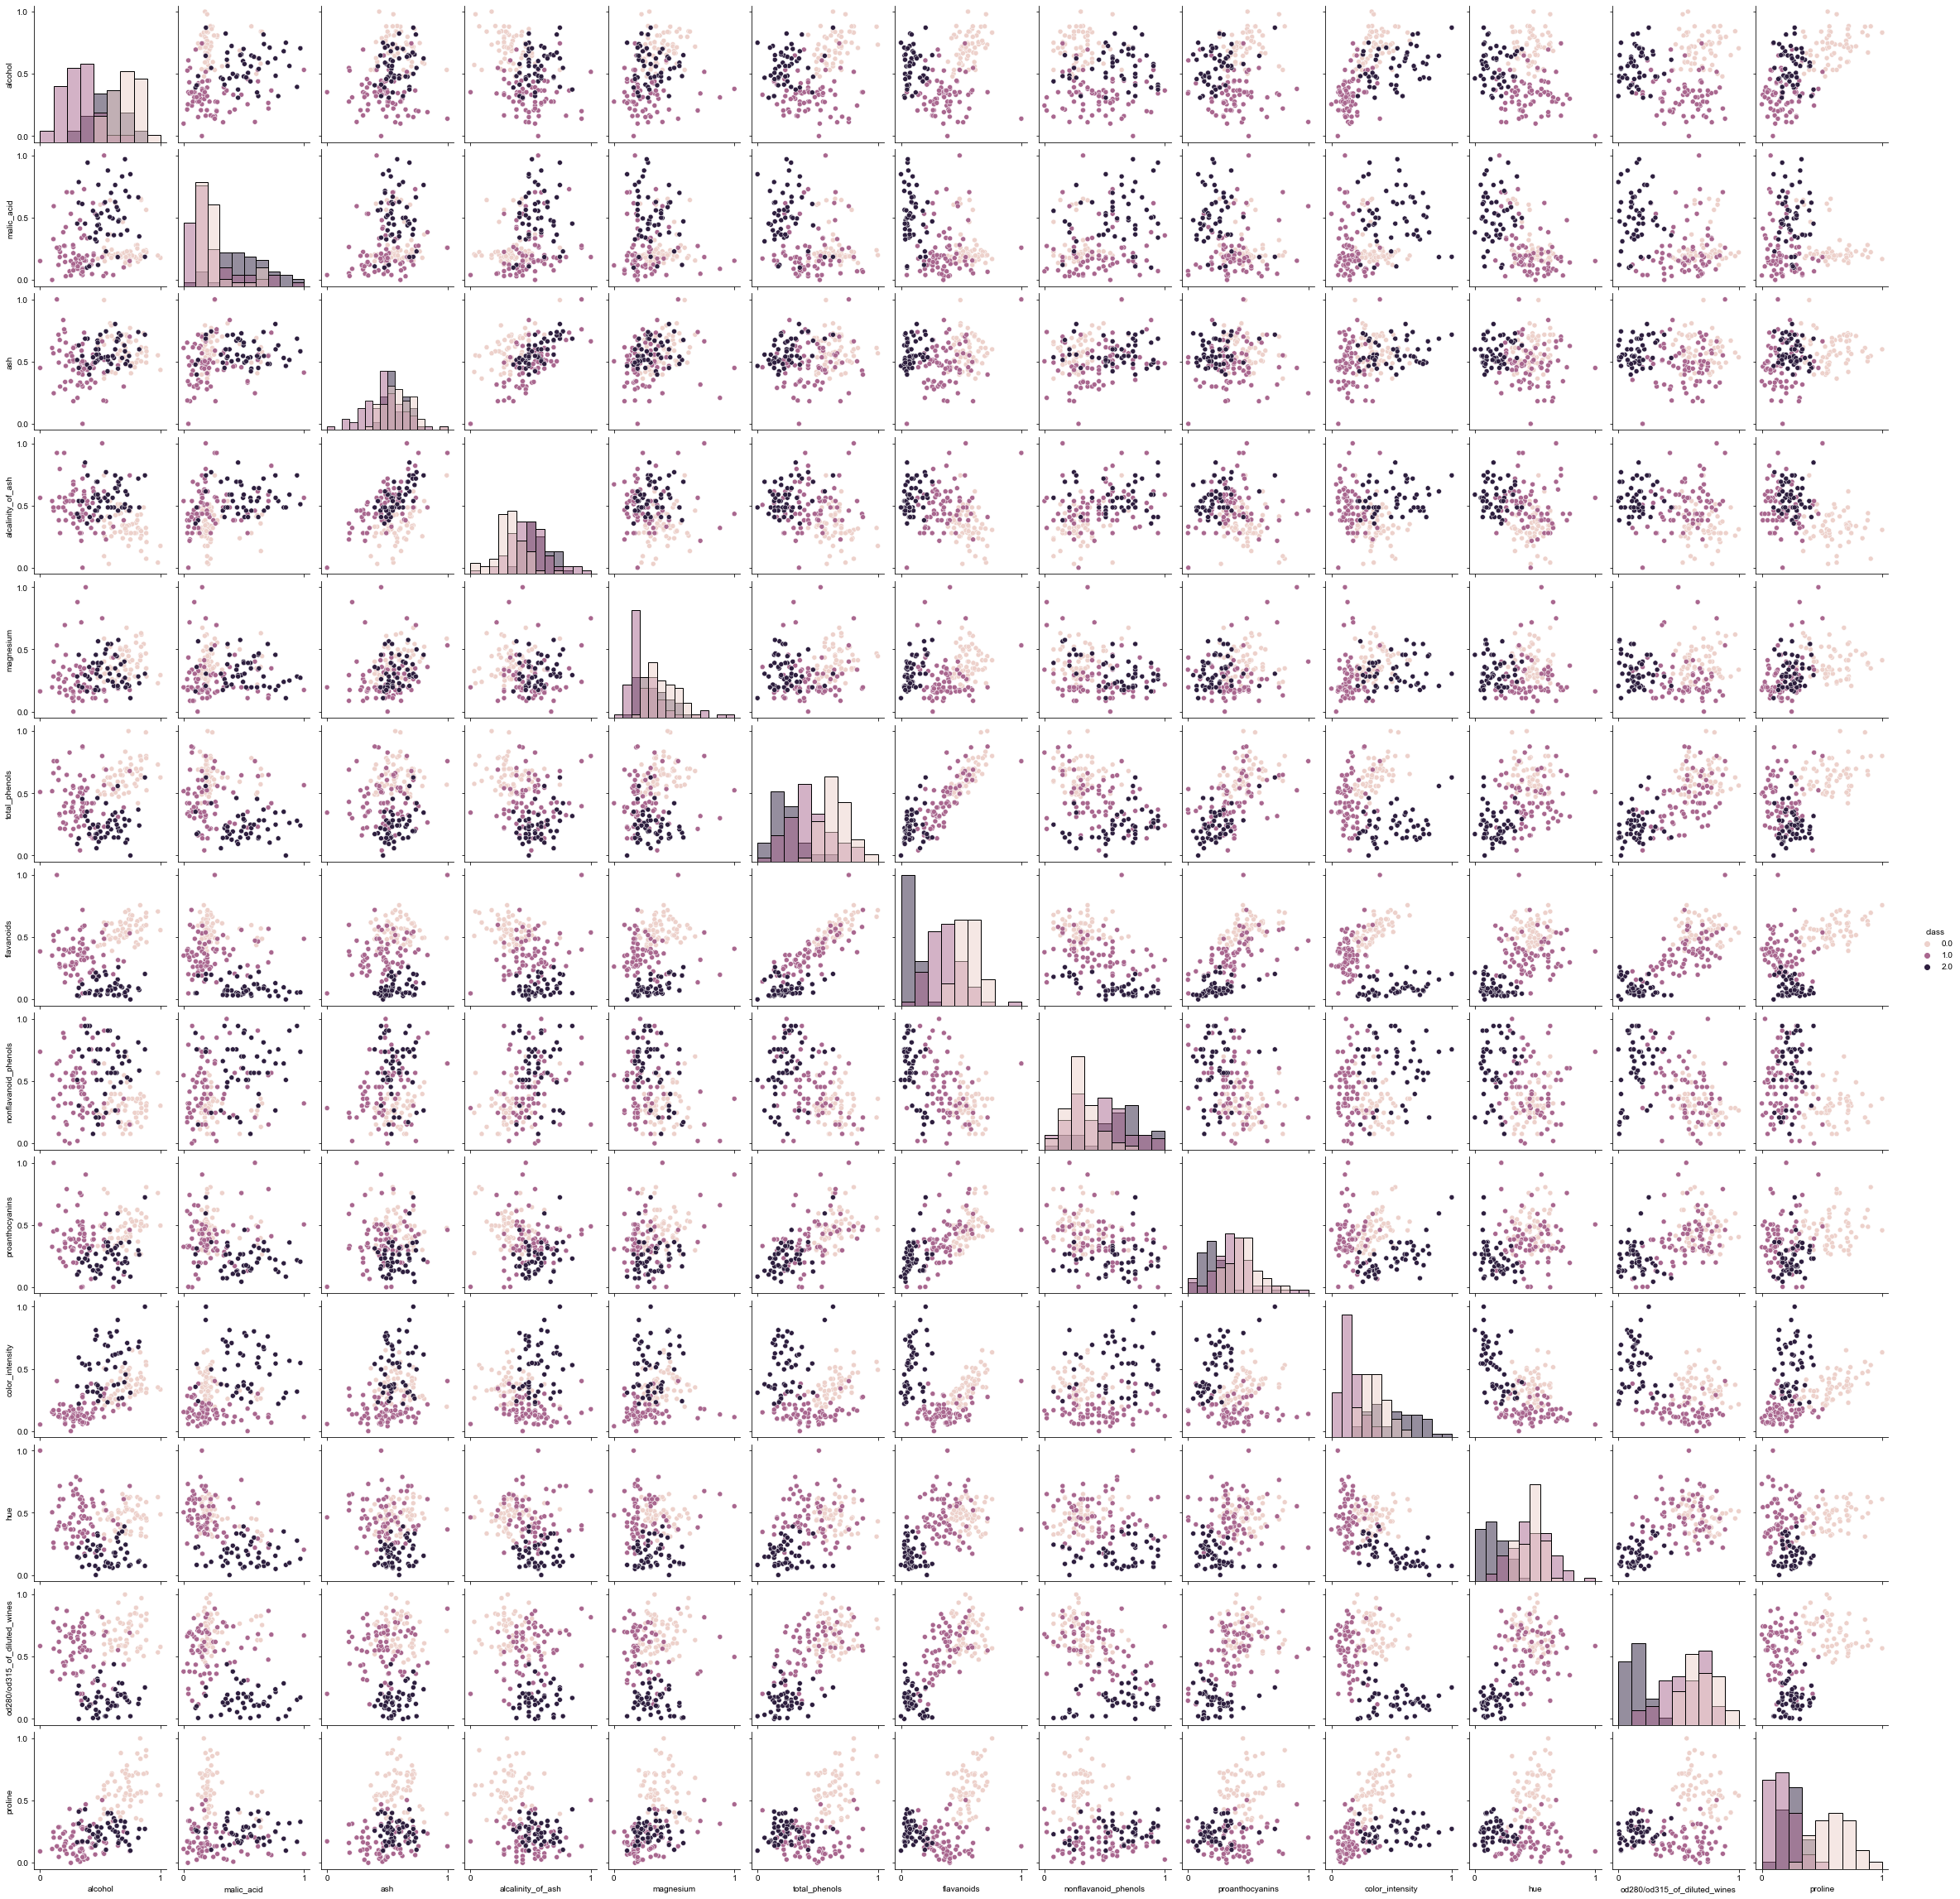

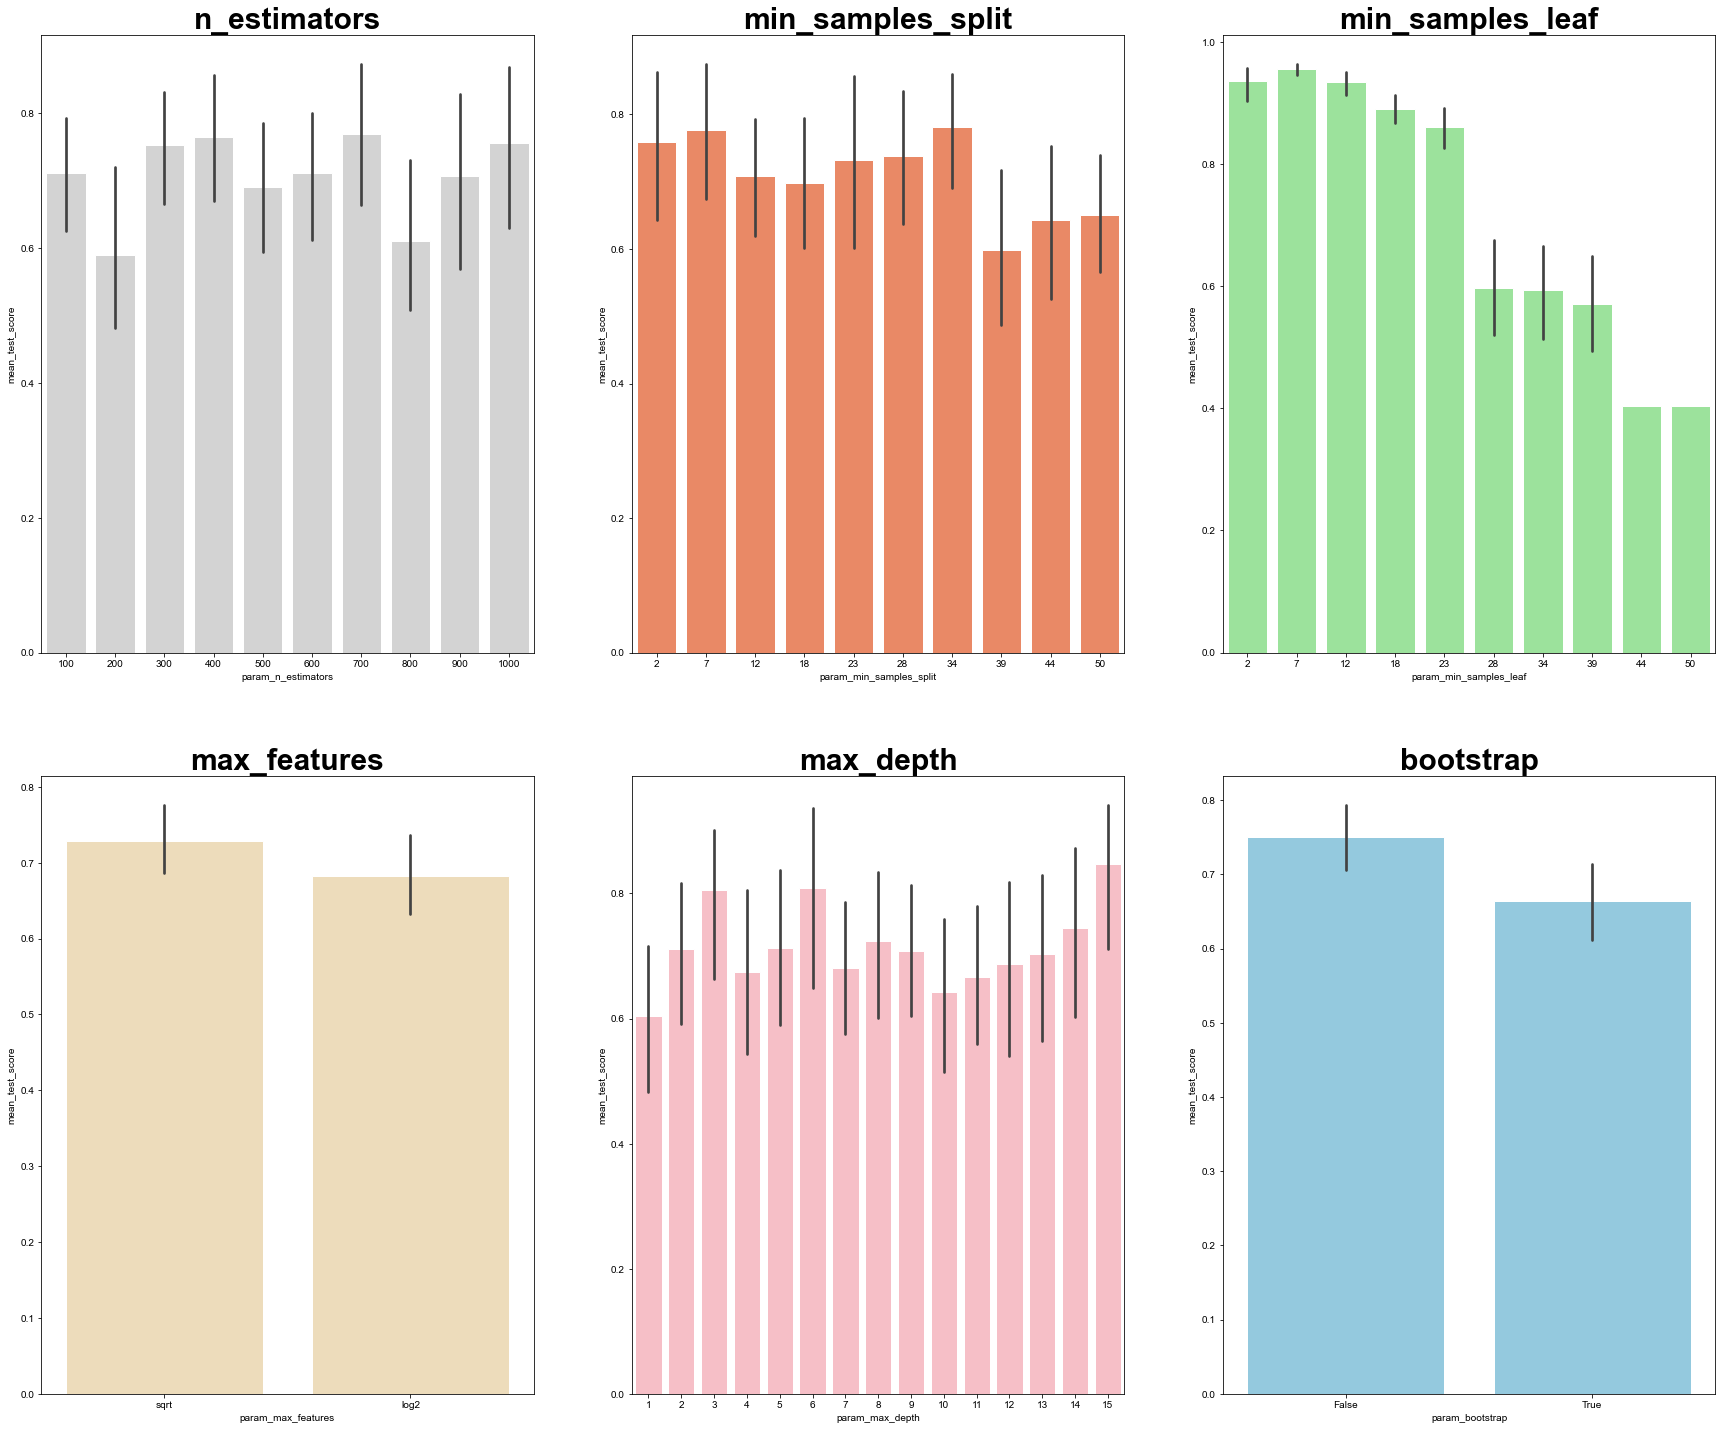

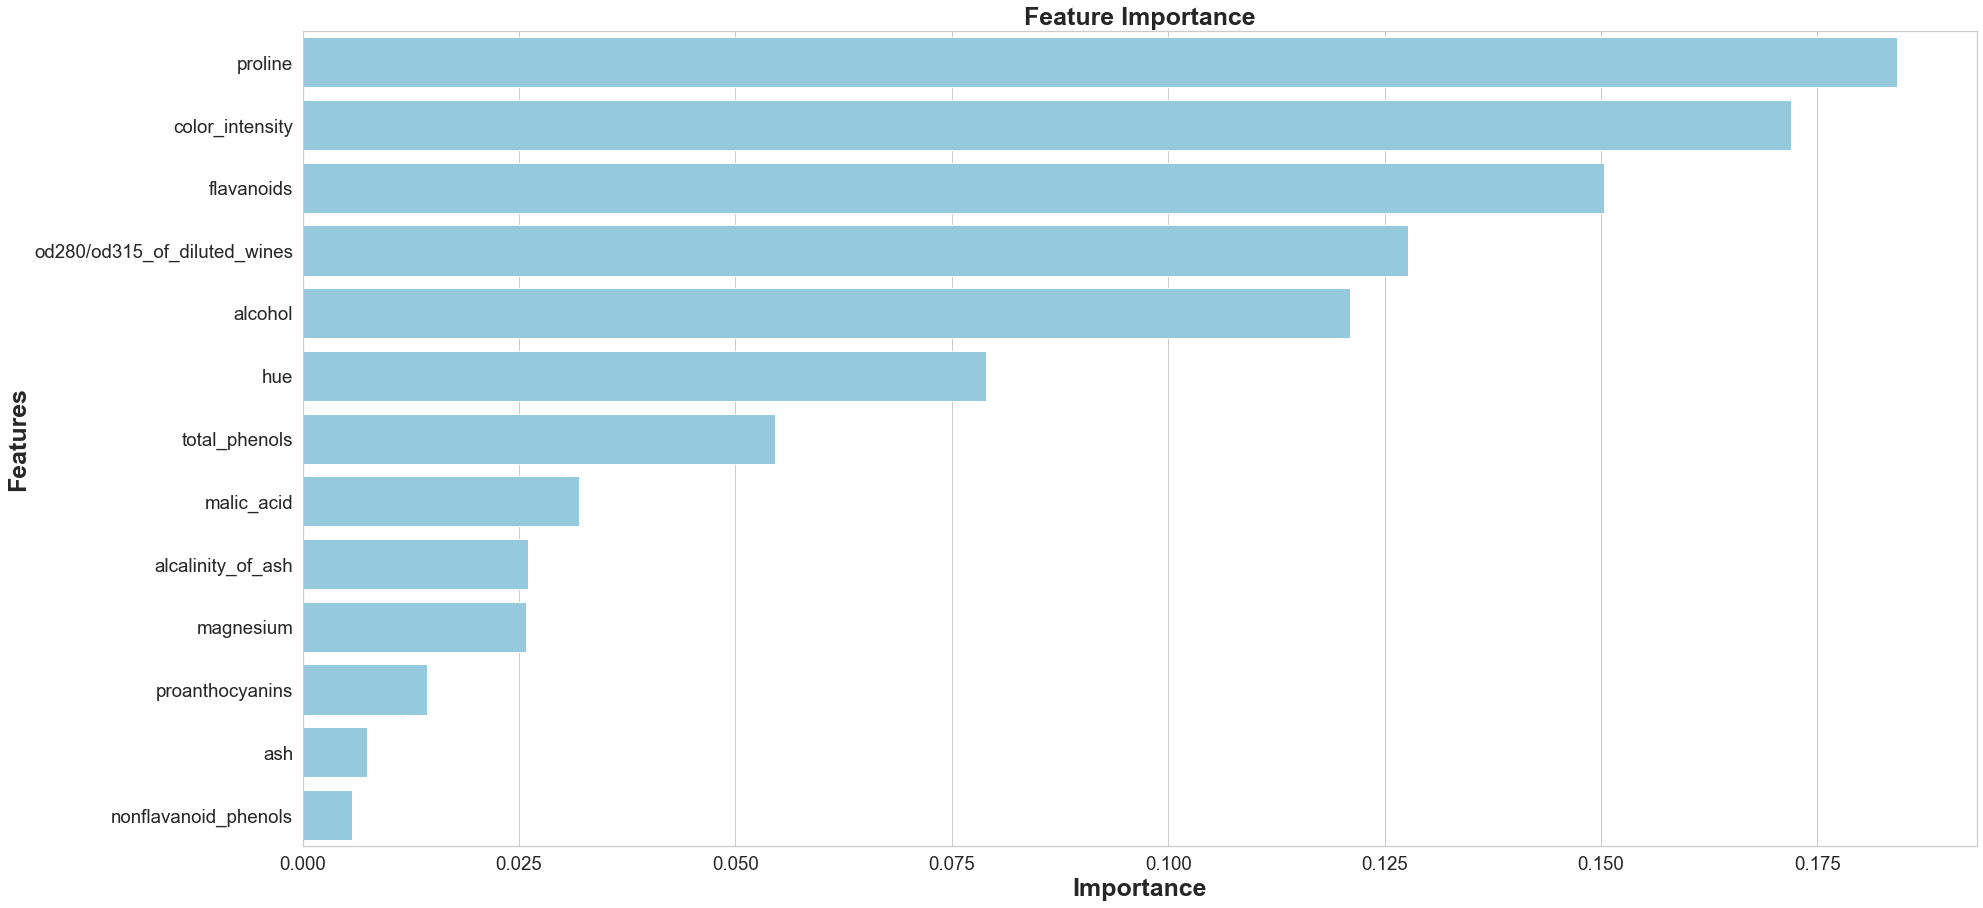

In [10]:
    # Load dataset
    columns, X, y = load_data(datasets.load_wine())

    get_features_correlations(X, y, columns)
    # train
    clf = ExtendedRandomForest(X, y, dataset=DATASET_NAME)
    clf.train(columns)